# 1. Dataloader from folder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

IMG_SIZE = 224
BATCH_SIZE = 32
DEGREES = 15
ROOT_I = 'Images'
gender_rev = {0: 'male', 1: 'female'}

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/UTKFace/'
image_datasets = {x: datasets.ImageFolder(data_dir+x,
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [c for c in image_datasets['train'].classes if c != ROOT_I]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


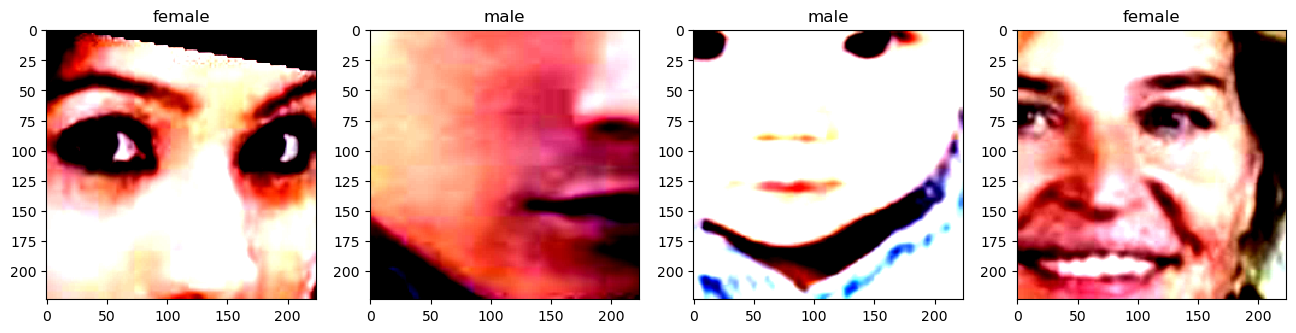

In [3]:
images, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(figsize=(16, 4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    img = images[ii]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    ax.set_title(gender_rev[int(labels[ii])])

# 2. Transfer learning using torch

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Generic training & visualizing funcions for any Torch model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            print(f'\t=> done {phase}')
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                npimg = inputs.cpu().data[j].numpy()
                ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
#                 plt.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Load the CNN (resnet-18)

# CNN as fixed feature extractor

# TODO: fix it with custom loss function

In [69]:
import torch.nn.functional as F
class FuzzyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='mean'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, F.one_hot(target.type(torch.int64)))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy 
        return torch.mean(loss) if self.reduction == 'mean' \
                                else torch.sum(loss) if self.reduction == 'sum' \
                                else loss

In [70]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
# criterion = nn.CrossEntropyLoss() # LOSS FUNCTION
criterion = FuzzyLoss(gamma=0.) # gamma=0 equivale a CrossEntropyLoss
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


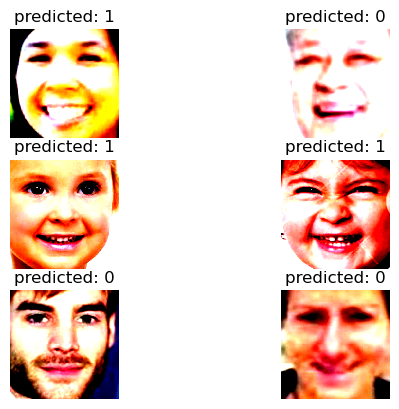

In [14]:
visualize_model(model_ft)
plt.ioff()
plt.show()

In [16]:
torch.save(model_ft.state_dict(), 'models/utk_rn18_m_f')

# Reuse model weights

In [6]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('models/utk_rn18_m_f'))
model = model.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


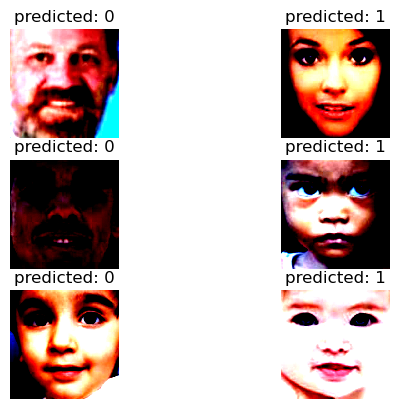

In [8]:
visualize_model(model)
plt.ioff()
plt.show()